Import the necessary packages.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

from tsai.data.preparation import SlidingWindowSplitter
import tsai.data.external
from tsai.inference import load_learner

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Read in the test data to evaluate the model when predicting the output sensor. In this example, we modeled the sensor 'Out2'.

In [2]:
df_test_Out2 = pd.read_parquet('./data_prepared/test/Out2.parquet')
df_test_Out2

,IN1,IN2,IN3,IN4,IN5,Out2
1970-01-10 08:00:00+00:00,-2.218704,-0.649350,-2.241375,-0.902478,-0.950451,-1.659219
1970-01-10 08:01:00+00:00,-2.212683,-0.596630,-2.237795,-0.894115,-0.967554,-1.404522
1970-01-10 08:02:00+00:00,-2.208265,-0.749858,-2.241937,-0.880259,-0.994613,-1.659219
1970-01-10 08:03:00+00:00,-2.196389,-0.601286,-2.255363,-0.868671,-1.010271,-1.786568
1970-01-10 08:04:00+00:00,-2.175124,-0.732468,-2.260804,-0.860698,-0.933107,-2.041265
...,...,...,...,...,...,...
1970-01-10 23:56:00+00:00,-2.371841,-1.399878,-2.594168,-0.861832,-1.607387,-1.531870
1970-01-10 23:57:00+00:00,-2.378745,-1.394332,-2.594168,-0.871577,-1.604817,-1.531870
1970-01-10 23:58:00+00:00,-2.385070,-1.388787,-2.594168,-0.880330,-1.579605,-1.659219
1970-01-10 23:59:00+00:00,-2.386119,-1.372902,-2.594168,-0.886744,-1.556761,-1.659219


Slice the testing data into chunks. Here 'get_x' and 'get_y' are indices to be used to select sensors in the 'tags' list, meaning we are using the selected features (according to our feature selection) to model the target sensor 'Out2'. A window length of 9 and a horizon of 0 mean we use 9 timesteps to predict the target at the last timestep in this window. The stride of 1 means we advance the window in 1 time step to create a new data chunk.

In [3]:
df_test = df_test_Out2.copy()
target = 'Out2'

tag_X = [s for s in df_test.columns if s != target and s != 'Time']
tag_y = target
tags = tag_X + [tag_y]

window_length = 9
stride = 1
horizon = 0
Xt_test, yt_test = SlidingWindowSplitter(window_length, stride=stride, horizon=horizon, get_x=list(range(len(tag_X))), get_y=len(tag_X))(df_test[tags])
print(Xt_test.shape, yt_test.shape)

(953, 5, 9) (953,)


The 'check_data' function allows us to inspect the data chunks to be used for model training.

In [4]:
tsai.data.external.check_data(Xt_test, yt_test)

X      - shape: [953 samples x 5 features x 9 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (953,)  type: ndarray  dtype:float64  isnan: 0


Load the learner object that was saved in the model training step and holds the model and its trained weights.

In [5]:
learner = load_learner('./models/learner.pkl')

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/serialization.py:882: UserWarning: This figure was saved with matplotlib version 3.2.2 and is unlikely to function correctly.
  result = unpickler.load()


Compute predictions on the test set.

In [6]:
%%capture --no-display

probs, _, preds = learner.get_X_preds(X=Xt_test)
preds = np.array(preds)

Compute the mean squared error between the true and predicted values for the test set.

In [7]:
mean_squared_error(yt_test, preds)

0.6041825427448522

Plot the sensor data corresponding to 'Out2' in the test data.

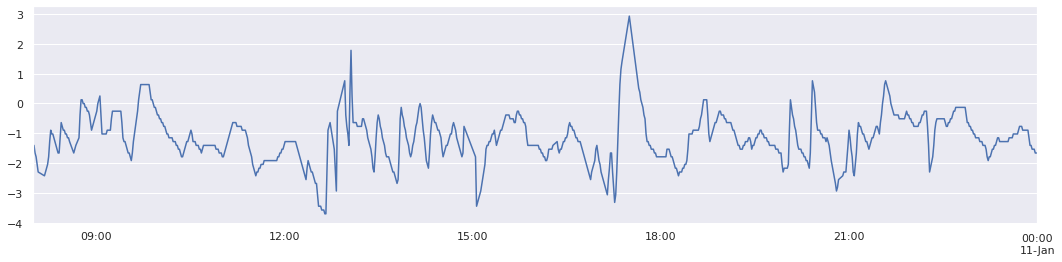

In [8]:
sns.set(rc={'figure.figsize':(18, 4), 'figure.max_open_warning':0})

df_test[target].plot()

Plot the actual and predicted values for Out2 in the test data. The second and third plots correspond to the first and last 240 timesteps in the test data, respectively. We also compute the mean squared error between actual and predicted values for the corresponding timesteps in the data.

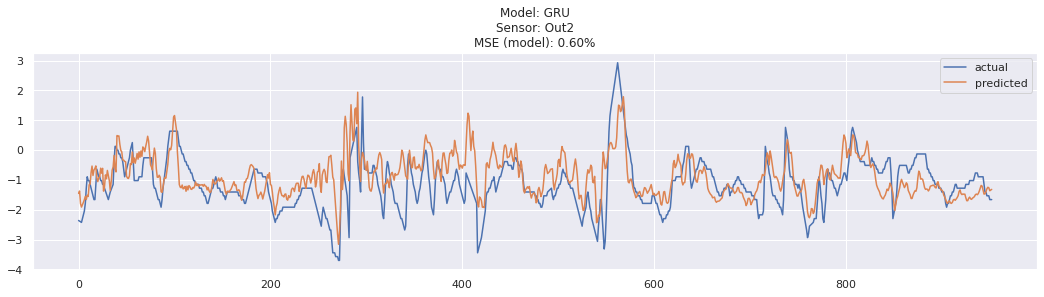

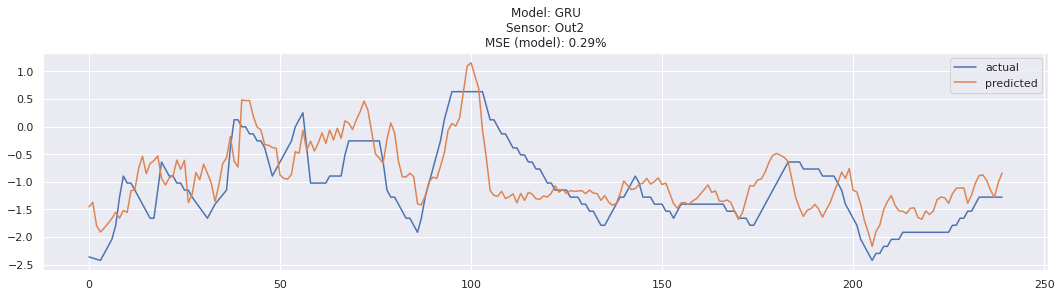

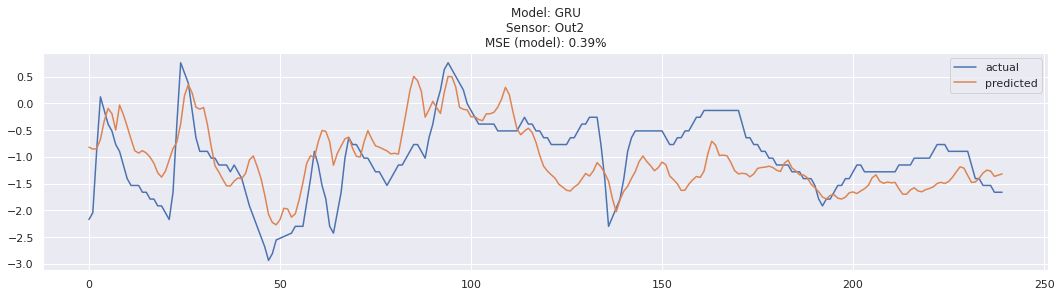

In [9]:
actual = df_test[target].to_numpy()[window_length-1:]
    
forecast = preds.squeeze(-1)

plt.figure()
pd.Series(actual).plot(label='actual')
pd.Series(forecast).plot(label='predicted')
mse_forecast_long = mean_squared_error(actual, forecast)
plt.title('Model: GRU' + '\n' + 'Sensor: ' + target + '\n' + 'MSE (model): {:.2f}%'.format(mse_forecast_long))
plt.legend()

plt.figure()
pd.Series(actual[0:240]).plot(label='actual')
pd.Series(forecast[0:240]).plot(label='predicted')
mse_forecast_short = mean_squared_error(actual[0:240], forecast[0:240])
plt.title('Model: GRU' + '\n' + 'Sensor: ' + target + '\n' + 'MSE (model): {:.2f}%'.format(mse_forecast_short))
plt.legend()

plt.figure()
pd.Series(actual[-240:]).plot(label='actual')
pd.Series(forecast[-240:]).plot(label='predicted')
mse_forecast_short = mean_squared_error(actual[-240:], forecast[-240:])
plt.title('Model: GRU' + '\n' + 'Sensor: ' + target + '\n' + 'MSE (model): {:.2f}%'.format(mse_forecast_short))
plt.legend()